# Fit growth models and extract growth statistics

This tutorial demonstrates how to fit growth models and extract growth statistics
using the growthcurves package.

The analysis workflow includes:
1. Generating or loading growth data
2. Fitting **mechanistic** models (ODE-based, parametric)
3. Fitting **phenomenological** models (parametric and non-parametric)
4. Extracting growth statistics from all fits
5. Saving results for visualization

For visualization of the results, see the companion notebook:
[`plotting.ipynb`](plotting.ipynb) (Visualize fitted growth curves, derivatives,
 and growth statistics)

In [1]:
from pprint import pprint

import numpy as np
import pandas as pd

import growthcurves as gc

## Data Preprocessing Functions

The growthcurves package provides preprocessing utilities for common data corrections:

- **`path_correct(N, path_length_cm)`**: Normalize OD measurements to 1 cm path length
- **`blank_subtraction(N, blank)`**: Subtract blank/background measurements from data

In [2]:
# Example 1: Path length correction
# Measurements taken with a 0.5 cm path length, normalized to 1 cm
raw_od_measurements = np.array([0.25, 0.30, 0.35, 0.40])
path_length = 0.5  # cm

od_corrected = gc.path_correct(raw_od_measurements, path_length)

print("Path Length Correction Example:")
print(f"  Raw OD (0.5 cm path): {raw_od_measurements}")
print(f"  Corrected OD (1 cm path): {od_corrected}")
print()

# Example 2: Blank subtraction
# Typical workflow: subtract blank measurements from sample data
sample_data = np.array([0.500, 0.600, 0.700, 0.800])
blank_data = np.array([0.050, 0.052, 0.048, 0.051])

corrected_data = gc.blank_subtraction(sample_data, blank_data)

print("Blank Subtraction Example:")
print(f"  Sample OD: {sample_data}")
print(f"  Blank OD:  {blank_data}")
print(f"  Corrected: {corrected_data}")
print()

# Example 3: Combined preprocessing workflow
# Simulate a typical preprocessing pipeline
raw_measurements = np.array([0.125, 0.150, 0.175, 0.200])
blank_measurements = np.array([0.025, 0.025, 0.025, 0.025])
path_length_cm = 0.5

# Step 1: Path correction
od_1cm = gc.path_correct(raw_measurements, path_length_cm)

# Step 2: Blank subtraction
od_corrected = gc.blank_subtraction(
    od_1cm, gc.path_correct(blank_measurements, path_length_cm)
)

print("Combined Preprocessing Pipeline:")
print(f"  Raw measurements (0.5 cm):     {raw_measurements}")
print(f"  After path correction (1 cm):  {od_1cm}")
print(
    f"  Blank (corrected to 1 cm):{gc.path_correct(blank_measurements, path_length_cm)}"
)
print(f"  Final corrected OD:            {od_corrected}")
print()

Path Length Correction Example:
  Raw OD (0.5 cm path): [0.25 0.3  0.35 0.4 ]
  Corrected OD (1 cm path): [0.5 0.6 0.7 0.8]

Blank Subtraction Example:
  Sample OD: [0.5 0.6 0.7 0.8]
  Blank OD:  [0.05  0.052 0.048 0.051]
  Corrected: [0.45  0.548 0.652 0.749]

Combined Preprocessing Pipeline:
  Raw measurements (0.5 cm):     [0.125 0.15  0.175 0.2  ]
  After path correction (1 cm):  [0.25 0.3  0.35 0.4 ]
  Blank (corrected to 1 cm):[0.05 0.05 0.05 0.05]
  Final corrected OD:            [0.2  0.25 0.3  0.35]



## Generate synthetic data

This cell generates synthetic growth data from a clean logistic function.
- time is modeled in hours, with measurements every 12 minutes (0.2 hours) for
  a total of 440 points (88 hours).
- We assume a lag of 30 hours, an intrinsic growth rate of 0.15 hour⁻¹,
  and a carrying capacity of 0.45 OD.

Doubling time at maximum acceleration point (t=35.08): 5.86 hours
Maximum specific growth rate (mu_max of log curve) at t=35.08: 0.11830 hour^-1


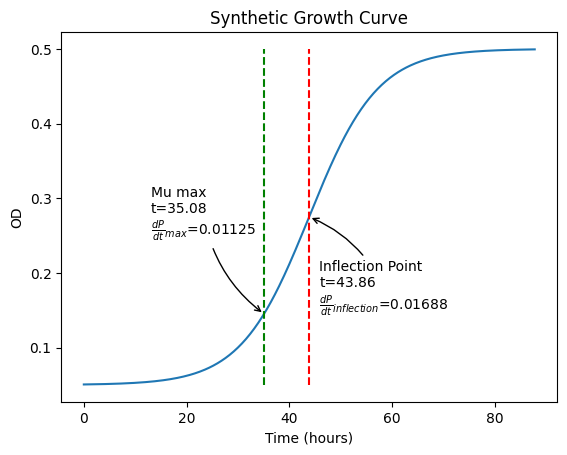

In [3]:
# Generate synthetic growth data from logistic function
np.random.seed(42)

# Parameters for synthetic growth curve
n_points = 440
measurement_interval_minutes = 12
t = np.array([(measurement_interval_minutes * n) / 60 for n in range(n_points)])


def logistic_growth(t, baseline, N0, K, mu, lag):
    """Logistic growth model with smooth transition through lag phase"""
    # Standard logistic formula centered at lag time
    # This creates a smooth S-curve with inflection point at t = lag + (K - N0) / N0
    factor = (K - N0) / N0
    growth = K / (1 + factor * np.exp(-mu * (t - lag)))
    return baseline + growth, lag + np.log(factor) / mu


def get_logistic_growth_and_rate(t, K, N0, mu, lag):
    """
    Returns (Population, Growth_Rate) at time t.
    """
    p_t, _ = logistic_growth(t, 0, N0, K, mu, lag)
    derivative = mu * p_t * (1 - (p_t / K))
    return p_t, derivative


def get_acceleration(t, K, N0, mu, lag):
    """
    Returns the acceleration (second derivative) at t t.
    """
    p_t, _ = get_logistic_growth_and_rate(t, K, N0, mu, lag)
    accel = mu**2 * p_t * (1 - (p_t / K)) * (1 - (2 * p_t / K))
    return accel


def get_doubling_time(t, K, N0, mu, lag):
    """
    Returns the instantaneous doubling time at time t.
    """
    p_t, _ = get_logistic_growth_and_rate(t, K, N0, mu, lag)
    with np.errstate(divide="ignore"):
        doubling_time = np.log(2) / (mu * (1 - (p_t / K)))
    return doubling_time


def log_transformed_derivative(t, K, N0, mu, lag):
    # Calculate P(t) first
    p_t, _ = get_logistic_growth_and_rate(t, K, N0, mu, lag)

    # The derivative of ln(P) is mu * (1 - P/K)
    log_der = mu * (1 - (p_t / K))

    return log_der


# Example: At the inflection point (where P = K/2)
# log_der = mu * (1 - 0.5) = 0.5 * mu

# Generate clean logistic curve
K = 0.45
mu = 0.15
N0 = 0.05
baseline = N0
lag = 30.0
N, t_inflec = logistic_growth(t, baseline=baseline, N0=N0, K=K, mu=mu, lag=lag)
N = N.tolist()

ax = pd.Series(N, index=t).plot(
    title="Synthetic Growth Curve", xlabel="Time (hours)", ylabel="OD"
)
_ = ax.vlines(
    t_inflec,
    ymin=N0,
    ymax=K + baseline,
    color="red",
    linestyle="--",
)
der_inflec, p_inflec = mu * K / 4, (K / 2 + N0)
_ = ax.annotate(
    f"Inflection Point\nt={t_inflec:.2f}\n"
    f"$\\frac{{dP}}{{dt}}_{{inflection}}$={der_inflec:.5f}",
    xy=(t_inflec, p_inflec),
    xytext=(t_inflec + 2, 0.15),
    arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"),
)
delta_t = np.log(2 + np.sqrt(3)) / mu
t_accel, p_accel = t_inflec - delta_t, K * (0.5 - np.sqrt(3) / 6)
_ = ax.vlines(
    t_accel,
    ymin=N0,
    ymax=K + baseline,
    color="green",
    linestyle="--",
)
der_max = 1 / 6 * mu * K
_ = ax.annotate(
    f"Mu max\nt={t_accel:.2f}\n$\\frac{{dP}}{{dt}}_{{max}}$={der_max:.5f}",
    xy=(t_accel, p_accel + baseline),  # Adjusted for baseline...
    xytext=(t_accel - 22, 0.25),
    arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"),
)
doubling_time_at_inflection = np.log(2) / (mu * (1 - (p_accel) / K))
print(
    "Doubling time at maximum acceleration point "
    f"(t={t_accel:.2f}): {doubling_time_at_inflection:.2f} hours"
)

max_mu = mu * (1 - ((p_accel) / K))
print(
    "Maximum specific growth rate (mu_max of log curve)"
    f" at t={t_accel:.2f}: {max_mu:.5f} hour^-1"
)

## How Growth Parameters Are Calculated

The table below summarizes how the main reported growth statistics are calculated
across model classes.

| Output key | Meaning | How it is calculated |
|---|---|---|
| `max_od` | Maximum observed/fitted OD | Maximum OD over the valid data range |
| `mu_max` | Maximum specific growth rate (μ_max) | Maximum of `d(ln N)/dt` from the fitted model (or local fit for non-parametric) |
| `intrinsic_growth_rate` | Intrinsic model rate parameter | For mechanistic models: fitted intrinsic `μ`; for phenomenological/non-parametric: `None` |
| `doubling_time` | Doubling time in hours | `ln(2) / mu_max` |
| `time_at_umax` | Time at maximum specific growth | Time where `mu_max` reaches its maximum |
| `od_at_umax` | OD at time of μ_max | Model-predicted OD at `time_at_umax` |
| `exp_phase_start`, `exp_phase_end` | Exponential phase boundaries | From threshold or tangent phase-boundary method in `extract_stats()` |
| `model_rmse` | Fit error | RMSE between observed OD and model-predicted OD over the model fit window |

For this tutorial:
- Mechanistic comparisons use mechanistic parametric fits.
- Phenomenological comparisons include both phenomenological parametric and non-parametric fits.


## Extract growth stats from the dataset

The `extract_stats_from_fit()` function calculates these key metrics:

- `max_od`: Maximum OD value within the fitted window
- `mu_max`: **Observed** maximum specific growth rate μ_max (hour⁻¹) - calculated
  from the fitted curve
- `intrinsic_growth_rate`: **Model parameter** for intrinsic growth rate
  (parametric models only, `None` for non-parametric)
- `doubling_time`: Time to double the population at peak growth (hours)
- `exp_phase_start`: When exponential phase begins (hours)
- `exp_phase_end`: When exponential phase ends (hours)
- `time_at_umax`: Time when μ reaches its maximum (hours)
- `od_at_umax`: OD value at time of maximum μ
- `fit_t_min`: Start of fitting window (hours)
- `fit_t_max`: End of fitting window (hours)
- `fit_method`: Identifier for the method used
- `model_rmse`: Root mean squared error

Descriptive parameters are extracted from the fits. Where parameters are not extracted
directly from the fitted model, they are calculated. The table below shows how
different stats are calculated according to the different approaches:

### MECHANISTIC MODELS

| Name | Model | Equation | Exp Start | Exp End | Intrinsic μ | μ max | Carrying Capacity | Fit |
|------|-------|----------|-----------|---------|-------------|-------|-------------------|-----|
| Logistic | parametric | `dN/dt = μ * (1 - N(t) / K) * N(t)` | threshold/<br>tangent | threshold/<br>tangent | μ | max dln(N)/dt | K | entire curve |
| Gompertz | parametric | `dN/dt = μ * math.log(K / N(t)) * N(t)` | threshold/<br>tangent | threshold/<br>tangent | μ | max dln(N)/dt | K | entire curve |
| Richards | parametric | `dN/dt = μ * (1 - (N(t) / K)**beta) * N(t)` | threshold/<br>tangent | threshold/<br>tangent | μ | max dln(N)/dt | A | entire curve |
| Baranyi | parametric | `dN/dt= μ * math.exp(μ * t) / (math.exp(h0) - 1 + math.exp(μ * t)) * (1 - N(t) / K) * N(t)` | threshold/<br>tangent | threshold/<br>tangent | μ | max dln(N)/dt | K | entire curve |

### PHENOMENOLOGICAL MODELS

| Name | Model | Equation | Exp Start | Exp End | Intrinsic μ | μ max | Max OD | Fit |
|------|-------|----------|-----------|---------|-------------|-------|--------|-----|
| Linear | non-parametric | `ln(N(t)) = N0 + b * t` | threshold/<br>tangent | threshold/<br>tangent | n.a. | b | max OD raw | only window |
| Spline | non-parametric | `ln(N(t)) = spline(t)` | threshold/<br>tangent | threshold/<br>tangent | n.a. | max of derivative of spline | max OD raw | only log phase |
| Logistic (phenom) | parametric | `ln(N(t)/N0) = A / (1 + exp(4 * μ_max * (λ - t) / A + 2))` | λ | threshold/<br>tangent | n.a. | μ_max | K | entire curve |
| Gompertz (phenom) | parametric | `ln(N(t)/N0) = A * exp(-exp(μ_max * exp(1) * (λ - t) / A + 1))` | λ | threshold/<br>tangent | n.a. | μ_max | K | entire curve |
| Gompertz (modified) | parametric | `ln(N(t)/N0) = A * exp(-exp(μ_max * exp(1) * (λ - t) / A + 1)) + A * exp(α * (t - t_shift))` | λ | threshold/<br>tangent | n.a. | μ_max | K | entire curve |
| Richards (phenom) | parametric | `ln(N(t)/N0) = A * (1 + ν * exp(1 + ν + μ_max * (1 + ν)**(1/ν) * (λ - t) / A))**(-1/ν)` | λ | threshold/<br>tangent | n.a. | μ_max | K | entire curve |

### Understanding Growth Rates: Intrinsic vs. Observed

**Important distinction:**

- **`mu_max`** (μ_max): The **observed** maximum specific growth rate calculated
  from the fitted curve as max(d(ln N)/dt). This is what you measure from the data.

- **`intrinsic_growth_rate`**: The **model parameter** representing intrinsic growth
  capacity:
  - **Parametric models**: This is a fitted parameter (e.g., `r` in Logistic,
    `mu_max` in Gompertz)
  - **Non-parametric methods**: Returns `None` (no model parameter exists)

## Mechanistic Models

Mechanistic models are ODE-based parametric models that encode growth dynamics as
differential equations.

### Fit Models

In [4]:
# Fit mechanistic models
fit_mech_logistic = gc.parametric.fit_parametric(t, N, method="mech_logistic")
fit_mech_gompertz = gc.parametric.fit_parametric(t, N, method="mech_gompertz")
fit_mech_richards = gc.parametric.fit_parametric(t, N, method="mech_richards")
fit_mech_baranyi = gc.parametric.fit_parametric(t, N, method="mech_baranyi")

# Combine fits into a dictionary
mechanistic_fits = {
    "mech_logistic": fit_mech_logistic,
    "mech_gompertz": fit_mech_gompertz,
    "mech_richards": fit_mech_richards,
    "mech_baranyi": fit_mech_baranyi,
}

# Display example fit result
print("=== Logistic Fit Result ===")
pprint(fit_mech_logistic, indent=2)

=== Logistic Fit Result ===
{ 'model_type': 'mech_logistic',
  'params': { 'K': np.float64(0.4499768424093958),
              'N0': np.float64(0.000625037163808368),
              'fit_t_max': 87.8,
              'fit_t_min': 0.0,
              'mu': np.float64(0.14992595235745404),
              'y0': np.float64(0.050009668374832776)}}


### Extract Growth Statistics

In [5]:
# Extract stats from each mechanistic fit
stats_mech_logistic = gc.inference.extract_stats(fit_mech_logistic, t, N)
stats_mech_gompertz = gc.inference.extract_stats(fit_mech_gompertz, t, N)
stats_mech_richards = gc.inference.extract_stats(fit_mech_richards, t, N)
stats_mech_baranyi = gc.inference.extract_stats(fit_mech_baranyi, t, N)

# Combine stats into a dictionary
mechanistic_stats = {
    "mech_logistic": stats_mech_logistic,
    "mech_gompertz": stats_mech_gompertz,
    "mech_richards": stats_mech_richards,
    "mech_baranyi": stats_mech_baranyi,
}

# Display growth statistics for logistic fit
print("=== Logistic Growth Statistics ===")
pprint(stats_mech_logistic, indent=2)

# Create comparison dataframe
print("\n=== Mechanistic Models Comparison ===")
mechanistic_df = pd.DataFrame(mechanistic_stats).T[
    [
        "mu_max",
        "intrinsic_growth_rate",
        "doubling_time",
        "time_at_umax",
        "exp_phase_start",
        "exp_phase_end",
        "model_rmse",
    ]
]
mechanistic_df.T

=== Logistic Growth Statistics ===
{ 'N0': 0.050009668374832776,
  'doubling_time': 8.86118100208731,
  'exp_phase_end': 59.48715239720588,
  'exp_phase_start': 12.91501548671014,
  'fit_method': 'model_fitting_mech_logistic',
  'fit_t_max': 87.8,
  'fit_t_min': 0.0,
  'intrinsic_growth_rate': 0.14992595235745404,
  'max_od': 0.49998651078422857,
  'model_rmse': 4.597890449519072e-05,
  'mu_max': 0.07822288929620892,
  'od_at_umax': 0.15665653300736812,
  'time_at_umax': 36.07014028056112}

=== Mechanistic Models Comparison ===


,mech_logistic,mech_gompertz,mech_richards,mech_baranyi
mu_max,0.078223,0.081681,0.081759,0.077833
intrinsic_growth_rate,0.149926,0.055765,0.187789,0.149806
doubling_time,8.861181,8.486063,8.477915,8.905564
time_at_umax,36.07014,22.873747,35.542285,36.246092
exp_phase_start,12.915015,6.520981,15.613275,12.870835
exp_phase_end,59.487152,65.012076,59.727912,59.522782
model_rmse,0.000046,0.02491,0.001558,0.00004


## Phenomenological Models - Parametric

These are phenomenological parametric models fit in ln-space.

### Fit Models

In [6]:
# Fit phenomenological parametric models
fit_phenom_logistic = gc.parametric.fit_parametric(t, N, method="phenom_logistic")
fit_phenom_gompertz = gc.parametric.fit_parametric(t, N, method="phenom_gompertz")
fit_phenom_gompertz_modified = gc.parametric.fit_parametric(
    t, N, method="phenom_gompertz_modified"
)
fit_phenom_richards = gc.parametric.fit_parametric(t, N, method="phenom_richards")

# Combine fits into a dictionary
phenom_param_fits = {
    "phenom_logistic": fit_phenom_logistic,
    "phenom_gompertz": fit_phenom_gompertz,
    "phenom_gompertz_modified": fit_phenom_gompertz_modified,
    "phenom_richards": fit_phenom_richards,
}

# Display example fit
print("=== Phenomenological Logistic Fit ===")
pprint(fit_phenom_logistic, indent=2)

=== Phenomenological Logistic Fit ===
{ 'model_type': 'phenom_logistic',
  'params': { 'A': np.float64(2.299980001980642),
              'N0': np.float64(0.050273088558506006),
              'fit_t_max': 87.8,
              'fit_t_min': 0.0,
              'lam': np.float64(21.9238038781274),
              'mu_max': np.float64(0.07997940767621518)}}


### Extract Growth Statistics

In [7]:
# Extract stats from each phenomenological parametric fit
stats_phenom_logistic = gc.inference.extract_stats(
    fit_phenom_logistic, t, N, phase_boundary_method="tangent"
)
stats_phenom_gompertz = gc.inference.extract_stats(
    fit_phenom_gompertz, t, N, phase_boundary_method="tangent"
)
stats_phenom_gompertz_modified = gc.inference.extract_stats(
    fit_phenom_gompertz_modified, t, N, phase_boundary_method="tangent"
)
stats_phenom_richards = gc.inference.extract_stats(
    fit_phenom_richards, t, N, phase_boundary_method="tangent"
)

# Combine stats into a dictionary
phenom_param_stats = {
    "phenom_logistic": stats_phenom_logistic,
    "phenom_gompertz": stats_phenom_gompertz,
    "phenom_gompertz_modified": stats_phenom_gompertz_modified,
    "phenom_richards": stats_phenom_richards,
}

# Display example stats
print("=== Phenomenological Logistic Stats ===")
pprint(stats_phenom_logistic, indent=2)

# Create comparison dataframe
print("\n=== Phenomenological Parametric Models Comparison ===")
phenom_param_df = pd.DataFrame(phenom_param_stats).T[
    [
        "mu_max",
        "intrinsic_growth_rate",
        "doubling_time",
        "time_at_umax",
        "exp_phase_start",
        "exp_phase_end",
        "model_rmse",
    ]
]
phenom_param_df.T

=== Phenomenological Logistic Stats ===
{ 'N0': 0.050273088558506006,
  'doubling_time': 8.66657056733965,
  'exp_phase_end': 50.65869644991835,
  'exp_phase_start': 21.9238038781274,
  'fit_method': 'model_fitting_phenom_logistic',
  'fit_t_max': 87.8,
  'fit_t_min': 0.0,
  'intrinsic_growth_rate': None,
  'max_od': 0.5005310454700512,
  'model_rmse': 0.0008165377630810787,
  'mu_max': 0.07997940767621518,
  'od_at_umax': 0.1580573708100321,
  'time_at_umax': 36.246092184368734}

=== Phenomenological Parametric Models Comparison ===


,phenom_logistic,phenom_gompertz,phenom_gompertz_modified,phenom_richards
mu_max,0.079979,0.092212,0.089873,0.078659
intrinsic_growth_rate,None,None,None,None
doubling_time,8.666571,7.516896,7.712561,8.812088
time_at_umax,36.246092,33.782766,33.430862,36.597996
exp_phase_start,21.923804,25.07681,23.467578,21.241111
exp_phase_end,50.658696,48.666283,48.628295,50.891908
model_rmse,0.000817,0.005205,0.00408,0.000506


## Phenomenological Models - Non-Parametric

These are phenomenological non-parametric fits that estimate growth features directly
from local trends and smoothing.

For spline fitting, use `smooth` to choose smoothing behavior:
- `smooth="fast"` (default): auto-default lambda rule
- `smooth="slow"`: weighted GCV smoothing
- `smooth=<float>`: manual lambda value

### Fit Models


In [ ]:
# Fit non-parametric models

# Spline supports smooth="fast" (default), smooth="slow", or a manual float.
fit_spline = gc.non_parametric.fit_non_parametric(
    t,
    N,
    method="spline",
    smooth="fast",
)

# Example manual smoothing value:
# fit_manual = gc.non_parametric.fit_non_parametric(t, N, method="spline", smooth=0.5)

fit_sliding_window = gc.non_parametric.fit_non_parametric(
    t,
    N,
    method="sliding_window",
    window_points=7,
)

# Combine fits into a dictionary
phenom_nonparam_fits = {
    "spline": fit_spline,
    "sliding_window": fit_sliding_window,
}

# Display non-parametric fit results
pprint(phenom_nonparam_fits, indent=2)

### Extract Growth Statistics

In [9]:
# Extract stats from each non-parametric fit
stats_spline = gc.inference.extract_stats(
    fit_spline,
    t,
    N,
    phase_boundary_method="tangent",
)

stats_sliding_window = gc.inference.extract_stats(
    fit_sliding_window,
    t,
    N,
    phase_boundary_method="tangent",
)

# Combine stats into a dictionary
phenom_nonparam_stats = {
    "spline": stats_spline,
    "sliding_window": stats_sliding_window,
}

# Create comparison dataframe
print("=== Phenomenological Non-Parametric Models Comparison ===")
phenom_nonparam_df = pd.DataFrame(phenom_nonparam_stats).T[
    [
        "mu_max",
        "intrinsic_growth_rate",
        "doubling_time",
        "time_at_umax",
        "exp_phase_start",
        "exp_phase_end",
        "model_rmse",
    ]
]
phenom_nonparam_df

=== Phenomenological Non-Parametric Models Comparison ===


,mu_max,intrinsic_growth_rate,doubling_time,time_at_umax,exp_phase_start,exp_phase_end,model_rmse
spline,0.076716,None,9.035244,36.620101,21.347067,51.183725,0.004767
sliding_window,0.077895,None,8.898485,36.0,21.566885,50.951931,0.000014


## Customizing Phase Boundary Detection

Two methods are available for determining exponential phase boundaries:

### 1. **Threshold Method**
- Tracks the instantaneous specific growth rate μ(t)
- `exp_phase_start`: First time when μ exceeds a fraction of μ_max (default: 15%)
- `exp_phase_end`: First time after peak when μ drops below the threshold

### 2. **Tangent Method**
- Constructs a tangent line in log space at the point of maximum growth rate
- Extends this tangent to intersect baseline (exp_phase_start) and plateau
  (exp_phase_end)

In [10]:
# Compare phase-boundary methods on the same fit
phase_boundary_rows = []

# Tangent method
stats_tangent = gc.inference.extract_stats(
    fit_spline,
    t,
    N,
    phase_boundary_method="tangent",
)
phase_boundary_rows.append(
    {
        "label": "tangent",
        "method": "tangent",
        "lag_threshold": np.nan,
        "exp_threshold": np.nan,
        "stats": stats_tangent,
    }
)

# Threshold method at different cutoffs
for frac, label in [(0.10, "threshold_low"), (0.30, "threshold_high")]:
    stats_threshold = gc.inference.extract_stats(
        fit_spline,
        t,
        N,
        phase_boundary_method="threshold",
        lag_threshold=frac,
        exp_threshold=frac,
    )
    phase_boundary_rows.append(
        {
            "label": label,
            "method": "threshold",
            "lag_threshold": frac,
            "exp_threshold": frac,
            "stats": stats_threshold,
        }
    )

# Create comparison dataframe
print("=== Phase Boundary Method Comparison ===")
phase_boundary_df = pd.DataFrame(
    [
        {
            "label": row["label"],
            "method": row["method"],
            "lag_threshold": row["lag_threshold"],
            "exp_threshold": row["exp_threshold"],
            "exp_phase_start": row["stats"]["exp_phase_start"],
            "exp_phase_end": row["stats"]["exp_phase_end"],
        }
        for row in phase_boundary_rows
    ]
)
phase_boundary_df

=== Phase Boundary Method Comparison ===


,label,method,lag_threshold,exp_threshold,exp_phase_start,exp_phase_end
0,tangent,tangent,NaN,NaN,21.347067,51.183725
1,threshold_low,threshold,0.1,0.1,9.766975,62.595430
2,threshold_high,threshold,0.3,0.3,18.076205,54.261244


See more details on the phase boundary methods in the next tutorial notebook:
[`plotting.ipynb`](plotting.ipynb) (Visualize fitted growth curves, derivatives,
and growth statistics)